In [1]:
import numpy as np
import matplotlib.pyplot as plt

from CartPole import CartPole

cp = CartPole()

In [2]:
# Generating data points for training the nonlinear model


def XY_data_generation(n, seeds):
    """
    Function for generating (X, Y) datapoints, used for model training.
       
    Target function Y is chosen to be the change in state after performAction()
    """
    X = []
    low = [-10,-10,-np.pi,-15]
    high = [10,10,np.pi,15]
    for i in range(4):
        np.random.seed(seeds[i])
        X.append(np.random.uniform(low[i], high[i], n))
    X = np.array(X).T

    Y = []

    for i in range(n):
        x = X[i]
        cp.setState(x)
        cp.performAction() 
        Y.append(cp.getState() - x)

    return np.array(X), np.array(Y)

In [5]:
# Functions involved in computing the nonlinear model

def kernel_compute(X, Xp, sig):
    """
    Returns a matrix K of dimension N x M, where
    N = no. of datapoints
    M = no. of basis functions
    """
    K = np.zeros((len(X), len(Xp)))
    for i in range(len(X)):
        for j in range(len(Xp)):
            exp_cl = (X[i][0] - Xp[j][0])**2 / (2*sig[0]**2)
            exp_cv = (X[i][1] - Xp[j][1])**2 / (2*sig[1]**2)
            exp_pa = np.sin((X[i][2] - Xp[j][2])/2)**2 / (2*sig[2]**2)
            exp_pv = (X[i][3] - Xp[j][3])**2 / (2*sig[3]**2)
            exponent = exp_cl + exp_cv + exp_pa + exp_pv
            K[i][j] = np.exp(-1*exponent)
    return K


def nonlinear_model(X, Y, M, sig, lmda):
    """
    Non-linear model: Does the matrix operations involving nonlinear model
    Returns the M sized vector alpha_M, used to compute the predictions
    """
    Xp_indices = np.random.choice(len(X), size=M, replace=False, p=None)
    Xp = X[Xp_indices]
    K_NM = kernel_compute(X, Xp, sig)
    K_MN = K_NM.T
    K_MM = kernel_compute(Xp, Xp, sig)
    a = K_MN @ K_NM + lmda * K_MM
    b = K_MN @ Y

    alpha_M = np.linalg.lstsq(a, b, rcond=None)[0]

    return alpha_M, Xp

In [19]:
# Generate data:

seeds = [0,1,2,3] # Seeds for each state variable 
N_train = 500    # We start with 1000 data points to train our nonlinear model

X_train, Y_train = XY_data_generation(N_train, seeds)

In [10]:
print(X_train[:20])
print(Y_train[:20])

[[  0.97627008  -1.65955991  -0.40215589   1.52393708]
 [  4.30378733   4.40648987  -2.97869333   6.24443468]
 [  2.05526752  -9.9977125    0.31203855  -6.27285783]
 [  0.89766366  -3.95334855  -0.40638139   0.32482816]
 [ -1.52690401  -7.06488218  -0.50034386  11.78840863]
 [  2.91788226  -8.1532281   -1.06603776  11.88879267]
 [ -1.24825577  -6.27479577  -1.85574736 -11.23244069]
 [  7.83546002  -3.08878546   0.74940158  -8.78271366]
 [  9.27325521  -2.06465052  -1.25880681 -13.4559839 ]
 [ -2.33116962   0.77633468  -1.46506744  -1.77570469]
 [  5.83450076  -1.61610971   0.76110632 -14.10371367]
 [  0.5778984    3.70439001   0.18310518  -1.29500327]
 [  1.36089122  -5.91095501  -2.29600192   4.47432143]
 [  8.51193277   7.56234873   0.08531385  -6.64538152]
 [ -8.57927884  -9.45224814  -1.9827228    5.28764706]
 [ -8.25741401   3.4093502    1.79281361   2.72588452]
 [ -9.59563205  -1.65390395   2.22409236 -14.28054353]
 [  6.65239691   1.17379657  -0.03621102   1.76562264]
 [  5.5631

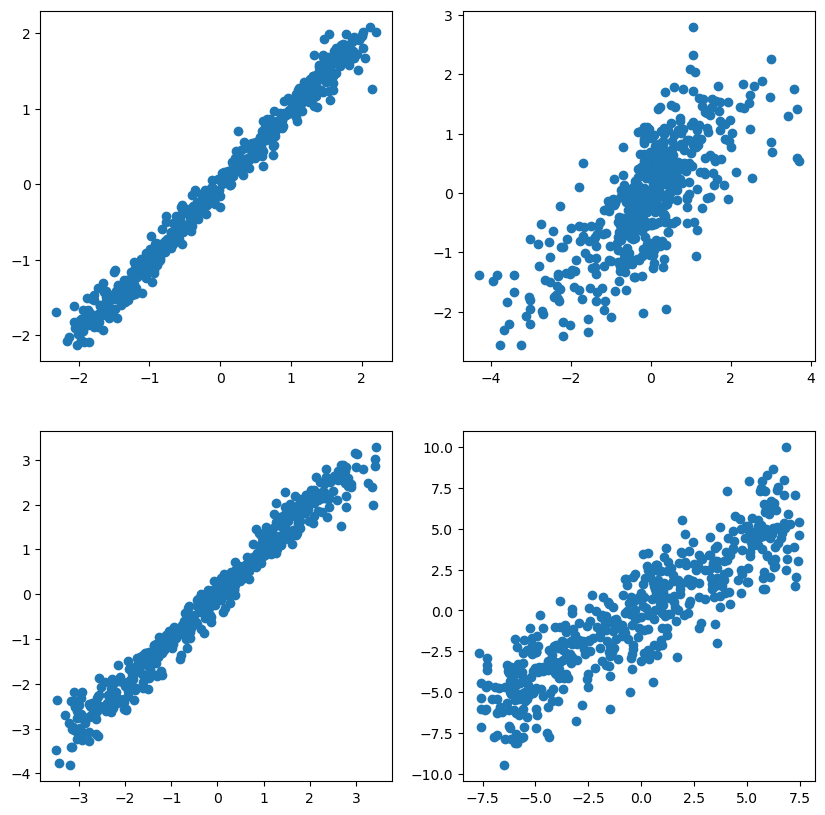

In [20]:
M = 50 # Number of basis functions 
lmda = 0.0001  # Preliminary value for the variance of the noise

std_list = []
for row in X_train.T:
    sq_mean = np.mean(np.square(row))
    mean = np.mean(row)
    variance = sq_mean - mean**2
    std_list.append(np.sqrt(variance))

alpha_M, Xp_train = nonlinear_model(X_train, Y_train, M, std_list, lmda)

K_NM = kernel_compute(X_train, Xp_train, std_list)

Y_pred = K_NM @ alpha_M

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(Y_train.T[0], Y_pred.T[0])
ax[0,1].scatter(Y_train.T[1], Y_pred.T[1])
ax[1,0].scatter(Y_train.T[2], Y_pred.T[2])
ax[1,1].scatter(Y_train.T[3], Y_pred.T[3])
plt.show()

In [13]:
# Now we need to find the optimal values for the length
# scale hyperparameters


# Write function for computing the mean squared error for a particular
# set of parameters

def find_mse(X, Y, M, sig, lmda):
    alpha_M, Xp = nonlinear_model(X, Y, M, sig, lmda)
    K_NM = kernel_compute(X, Xp, sig)
    Y_pred = K_NM @ alpha_M
    mse = np.square(Y_pred-Y).mean(axis=0)
    return mse

# Multiply the standard deviation by various scale factors to
# perform the grid search over:

# scale_factors = np.geomspace(0.01, 100, 100)
# # List of 100 scale factors to multiply each standard deviation by



# We start by trying a grid search, to narrow down the optimal value for
# the sigmas

# # List of 5 scale factors to multiply each standard deviation by
# scale_factors = np.geomspace(0.1, 10, 5)


# sigma_range_0 = std_list[0] * scale_factors
# sigma_range_1 = std_list[1] * scale_factors
# sigma_range_2 = std_list[2] * scale_factors
# sigma_range_3 = std_list[3] * scale_factors

# # Manual grid search to find the optimal combination of sigmas
# # May take an inordinate amount of time to run

# opt_mse = np.inf
# opt_sig = []
# count = 1
# for s0 in sigma_range_0:
#     for s1 in sigma_range_1:
#         for s2 in sigma_range_2:
#             for s3 in sigma_range_3:
#                 sig = [s0, s1, s2, s3]
#                 mse = np.sum(find_mse(X_train, Y_train, M, sig, lmda))
#                 if mse < opt_mse:
#                     opt_mse = mse
#                     opt_sig = sig
#                 print(f"{count}/625", mse)
#                 count += 1

# print(opt_mse, opt_sig)

In [21]:
# We start by trying a grid search, to narrow down the optimal value for
# the sigmas

# List of 5 scale factors to multiply each standard deviation by
scale_factors = np.geomspace(0.1, 10, 5)


sigma_range_0 = std_list[0] * scale_factors
sigma_range_1 = std_list[1] * scale_factors
sigma_range_2 = std_list[2] * scale_factors
sigma_range_3 = std_list[3] * scale_factors

# Manual grid search to find the optimal combination of sigmas
# May take an inordinate amount of time to run

opt_mse = np.inf
opt_sig = []
count = 1
for s0 in sigma_range_0:
    for s1 in sigma_range_1:
        for s2 in sigma_range_2:
            for s3 in sigma_range_3:
                sig = [s0, s1, s2, s3]
                mse = np.sum(find_mse(X_train, Y_train, M, sig, lmda))
                if mse < opt_mse:
                    opt_mse = mse
                    opt_sig = sig
                print(f"{count}/625", mse)
                count += 1

print(opt_mse, opt_sig)

1/625 21.45490983679912
2/625 21.291931545006662
3/625 21.740027596934144
4/625 21.793334080164342
5/625 20.82543477461024
6/625 21.479612285645715
7/625 20.978342855636377
8/625 21.50707324662052
9/625 21.514451648085537
10/625 21.00910511156952
11/625 22.001179218263708
12/625 21.330091207500875
13/625 21.57955256105363
14/625 21.60126657103155
15/625 22.067829164319804
16/625 22.059191464833482
17/625 21.523072966597862
18/625 21.297488559380295
19/625 21.641508564711376
20/625 21.579942222487425
21/625 21.59787397867459
22/625 21.502704084637095
23/625 21.076847942693114
24/625 21.338660278771723
25/625 21.585436424837056
26/625 21.36118923992784
27/625 20.9345546889354
28/625 20.577767268617052
29/625 20.11110642299454
30/625 20.727824892900344
31/625 21.71740966103669
32/625 20.857740890096707
33/625 20.109947331238892
34/625 20.314561035688328
35/625 20.077303422022354
36/625 21.477203164771353
37/625 20.853148388494834
38/625 20.546876630689724
39/625 20.643886451939007
40/625 